In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [2]:
df = pd.read_csv("embeddings/concatenated_multimodal_embedding.csv")

In [4]:
df = df.drop(columns=["Unnamed: 0"])

In [6]:
df = df.drop(columns=["participant_id", "id_day"])

In [8]:
tasks = ["Depression", "Anxiety"]
task = tasks[0]  # Change to 1 for anxiety prediction

if task == "Depression":
    print("data for task:", task)
    X = df.drop(columns=["Depression", "Anxiety"]).values
    y = df["Depression"].values
    print(X.shape, y.shape)
   
if task == "Anxiety":
    print("data for task:", task)
    X = df.drop(columns=["Depression", "Anxiety"]).values
    y = df["Anxiety"].values
    print(X.shape, y.shape)



data for task: Depression
(106, 7552) (106,)


In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([79, 7552]) torch.Size([79, 1])
torch.Size([27, 7552]) torch.Size([27, 1])


In [13]:
class MLP_1LAYER(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, dropout=0.1):
        super().__init__()
        self.hc1 = nn.Linear(input_dim, output_dim)
        self.act = nn.ReLU()
        self.out_act = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)


    def forward(self, input):
        h = self.act(self.hc1(input))
        return self.out_act(h)


class CNN_1D(nn.Module):
    def __init__(self, input_dim, output_dim, num_filters=64, kernel_size=3, dropout=0.1, pool_size=2):
        super().__init__()
        self.conv1 = nn.Conv1d(1, num_filters, kernel_size)
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.pool = nn.MaxPool1d(pool_size)
        self.dropout = nn.Dropout(dropout)
        
        conv_output_dim = (input_dim - kernel_size + 1) // pool_size
        self.fc1 = nn.Linear(num_filters * conv_output_dim, output_dim)

        self.act = nn.ReLU()
        self.out_act = nn.Sigmoid()  

    def forward(self, x):
        x = x.unsqueeze(1)                   
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return self.out_act(x)  
    



In [94]:
    
layer =2# 1, 2
models = {
    1: MLP_1LAYER,
    2: CNN_1D,
}
lr_parameter = 1e-6
num_epochs = 50         
dropout = 0
input_dim = X_train.shape[1]
print(input_dim)
output_dim = 1  # Para clasificación binaria
hidden_dim0 = 32
hidden_dim1 = 64
hidden_dim2 = 128
hidden_dim3 = 256
hidden_dim4 = 512
hidden_dim = hidden_dim1


num_filters = 16
kernel_size = 3



criterion = nn.BCELoss()  
#model = models[layer](input_dim, output_dim, hidden_dim, dropout)
model = models[layer](input_dim, output_dim, num_filters=num_filters, kernel_size=kernel_size, dropout=dropout)
model_name = models[layer].__name__
print(model)
print("Model name:", model_name)
optimizer = optim.AdamW(model.parameters(), lr=lr_parameter, weight_decay=1e-5)



7552
CNN_1D(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=60400, out_features=1, bias=True)
  (act): ReLU()
  (out_act): Sigmoid()
)
Model name: CNN_1D


In [95]:
losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    logits = model(X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

    # Evaluar en validación
    model.eval()
    with torch.no_grad():
        val_logits = model(X_test)
        val_loss = criterion(val_logits, y_test)

    losses.append((loss.item(), val_loss.item()))



    # Imprimir cada 5 épocas
    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {loss.item():.6f}, Val Loss = {val_loss.item():.6f}")



Epoch 1: Train Loss = 0.733245, Val Loss = 0.681268
Epoch 2: Train Loss = 0.727354, Val Loss = 0.679476
Epoch 3: Train Loss = 0.721781, Val Loss = 0.677548
Epoch 4: Train Loss = 0.716530, Val Loss = 0.675978
Epoch 5: Train Loss = 0.711602, Val Loss = 0.674689
Epoch 6: Train Loss = 0.706996, Val Loss = 0.673552
Epoch 7: Train Loss = 0.702708, Val Loss = 0.672390
Epoch 8: Train Loss = 0.698732, Val Loss = 0.671421
Epoch 9: Train Loss = 0.695058, Val Loss = 0.670664
Epoch 10: Train Loss = 0.691675, Val Loss = 0.670091
Epoch 11: Train Loss = 0.688567, Val Loss = 0.669742
Epoch 12: Train Loss = 0.685719, Val Loss = 0.669524
Epoch 13: Train Loss = 0.683111, Val Loss = 0.669415
Epoch 14: Train Loss = 0.680724, Val Loss = 0.669362
Epoch 15: Train Loss = 0.678537, Val Loss = 0.669364
Epoch 16: Train Loss = 0.676529, Val Loss = 0.669514
Epoch 17: Train Loss = 0.674679, Val Loss = 0.669801
Epoch 18: Train Loss = 0.672965, Val Loss = 0.670137
Epoch 19: Train Loss = 0.671369, Val Loss = 0.670537
Ep

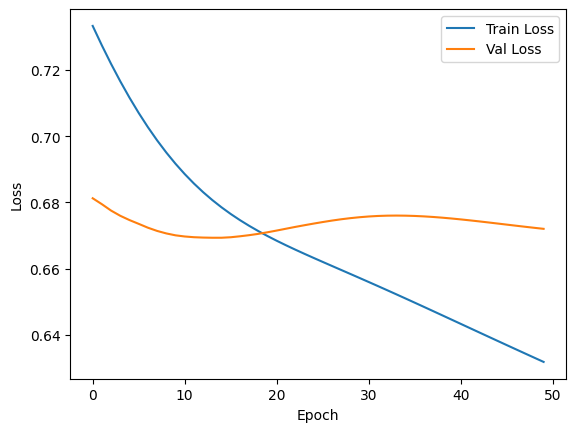

In [96]:
###graficar losses
train_losses, val_losses = zip(*losses)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_loss_curve.png")
#plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_loss_curve.png")
#plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_PCA95_loss_curve.png")
#plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_PCA95_loss_curve.png")
plt.show()

In [97]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score, precision_score

# Evaluación del modelo
model.eval()
with torch.no_grad():
    probs = model(X_test)
    preds = (probs > 0.5).float()  # umbral de 0.5


print(classification_report(y_test, preds))

f1 = f1_score(y_test, preds)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

recall = recall_score(y_test, preds)
print("Recall:", recall)

precision = precision_score(y_test, preds)
print("Precision:", precision)




report = classification_report(y_test, preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()
path = "results_10_experiments/cnn/"
id = "9"
#report_filename = f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_metrics.csv"
#report_filename = f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_metrics.csv"
#report_filename = f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_PCA95_metrics.csv"
report_filename =  path + f"id_{id}_" + f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_kernel{kernel_size}_num{num_filters}_metrics.csv"
report_df.to_csv(report_filename, index=True)


              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        16
         1.0       1.00      0.09      0.17        11

    accuracy                           0.63        27
   macro avg       0.81      0.55      0.46        27
weighted avg       0.77      0.63      0.52        27

F1 Score: 0.16666666666666666
Accuracy: 0.6296296296296297
Recall: 0.09090909090909091
Precision: 1.0


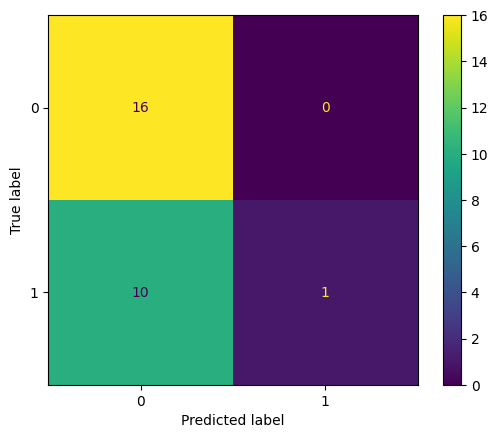

In [98]:
# grafico matriz de confusión default
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
model.eval()
with torch.no_grad():
    probs = model(X_test)
    preds = (probs > 0.5).float()  # umbral de 0.5
cm = confusion_matrix(y_test, preds)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
#plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_confusion_matrix.png")
#plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_confusion_matrix.png")
#plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_PCA95_confusion_matrix.png")
plt.savefig(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_PCA95_confusion_matrix.png")
plt.show()


#save losses in csv
losses_df = pd.DataFrame(losses, columns=['Train Loss', 'Val Loss'])
#losses_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_losses.csv", index=False)
#losses_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_losses.csv", index=False)
#losses_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_PCA95_losses.csv", index=False)
losses_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_PCA95_losses.csv", index=False)

#save results and f1 score, acurracy, recall in csv
results_df = pd.DataFrame({'True': y_test.numpy().flatten(), 'Predicted': preds.numpy().flatten()})
#results_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_results.csv", index=False)
#results_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_results.csv", index=False)
#results_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_PCA95_results.csv", index=False)
results_df.to_csv(f"{model_name}_{task}_lr{lr_parameter}_epochs{num_epochs}_dropout{dropout}_hidden{hidden_dim}_kernel_size{kernel_size}_num_filters{num_filters}_PCA95_results.csv", index=False)